In [1]:
## necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages

In [2]:
## loading the train and the test sets

train = pd.read_csv('Google_Stock_Price_Train.csv', usecols=['Date', 'Open']) ## Open -> opening stock price for the day
test = pd.read_csv('Google_Stock_Price_Test.csv', usecols=['Date', 'Open'])

## 'Date': str --> datetime, set as index

train['Date'] = train['Date'].apply(lambda str_date: pd.to_datetime(str_date))
train.set_index('Date', inplace=True)

test['Date'] = test['Date'].apply(lambda str_date: pd.to_datetime(str_date))
test.set_index('Date', inplace=True)

In [3]:
train.head()

,Open
Date,
2012-01-03,325.25
2012-01-04,331.27
2012-01-05,329.83
2012-01-06,328.34
2012-01-09,322.04


In [4]:
test.head()

,Open
Date,
2017-01-03,778.81
2017-01-04,788.36
2017-01-05,786.08
2017-01-06,795.26
2017-01-09,806.40


In [5]:
train.shape

(1258, 1)

In [6]:
test.shape

(20, 1)

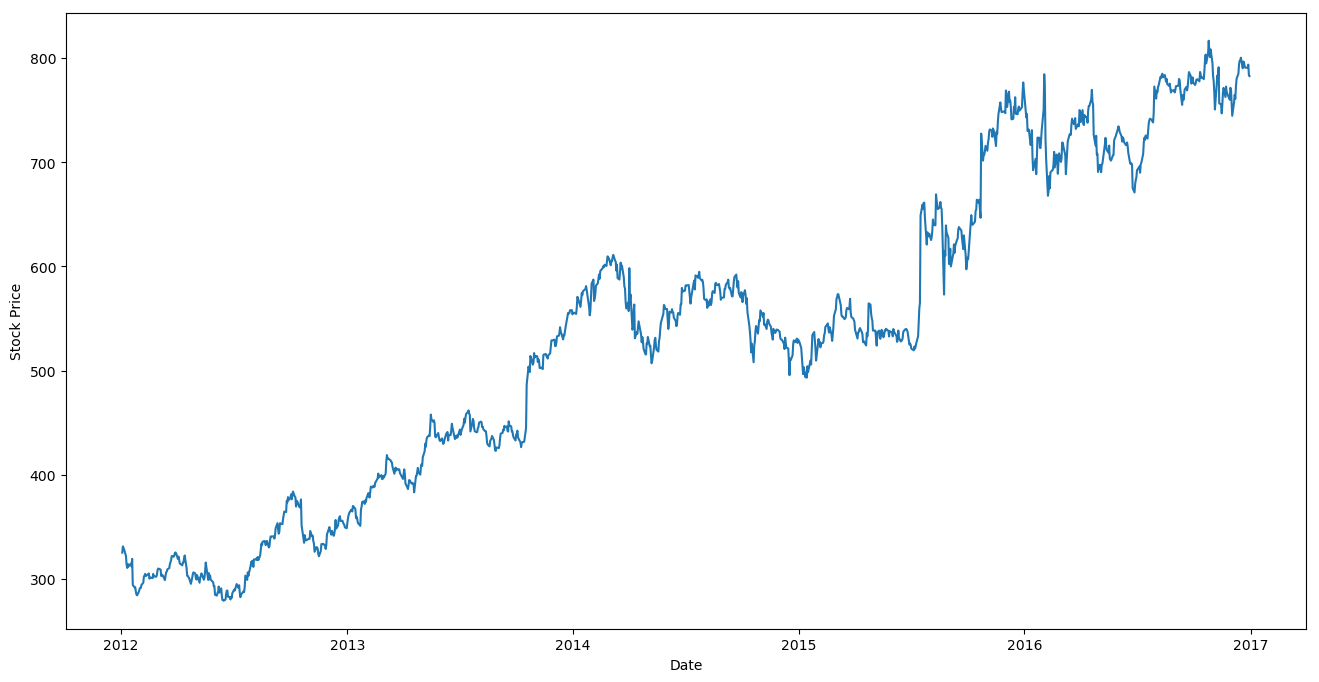

In [7]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(train['Open'])
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

plt.show()

In [8]:
## normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)
scaled_train_data = scaler.transform(train)

In [9]:
## time steps --> no. of previous values as input to LSTM to make predictions
## time_steps = 60 (feel free to experiment with different values)

time_steps = 60

In [10]:
## feature label split

X = list()
y = list()

for i in range(time_steps, len(scaled_train_data)):
    X.append(scaled_train_data[i-time_steps:i,0].reshape(time_steps))
    y.append(scaled_train_data[i,0])
    
X, y = np.array(X), np.array(y)

## ADDING A NEW DIMESION TO X_TRAIN

## TWO REASONS:
## ONE --> KERAS RNN LAYERS NEED AN INPUT OF DIMESION (BATCH_SIZE, TIMESTEPS, INPUT_DIM), INPUT_DIM --> NO. OF PREDICTORS
## TWO --> IT ENABLES US TO ADD OTHER PREDICTORS FOR TRAINING. E.G., STOCK PRICES FOR SIMILAR TECH COMPANIES

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

## train validation split

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=27)

In [11]:
X_train.shape

(958, 60, 1)

In [12]:
X_validation.shape

(240, 60, 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [14]:
## initialization
regressor = Sequential()

## LSTM 1
regressor.add(LSTM(units=X_train.shape[1], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 2
regressor.add(LSTM(units=X_train.shape[1], return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 3
regressor.add(LSTM(units=X_train.shape[1], return_sequences=True))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## LSTM 2
regressor.add(LSTM(units=X_train.shape[1]))
regressor.add(Dropout(rate=0.2)) ## turns off 20% perceptrons during training to prevent overfitting

## Output
regressor.add(Dense(units=1))

## Compile
regressor.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [15]:
## model fit
history = regressor.fit(x=X_train, y=y_train, batch_size=32, epochs=400, validation_data=[X_validation, y_validation])

Train on 958 samples, validate on 240 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/400
958/958 [==============================] - 7s 7ms/sample - loss: 0.0542 - val_loss: 0.0049
Epoch 2/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0055 - val_loss: 0.0021
Epoch 3/400
958/958 [==============================] - 4s 5ms/sample - loss: 0.0051 - val_loss: 0.0020
Epoch 4/400
958/958 [==============================] - 5s 5ms/sample - loss: 0.0051 - val_loss: 0.0025
Epoch 5/400
958/958 [==============================] - 5s 5ms/sample - loss: 0.0049 - val_loss: 0.0020
Epoch 6/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0041 - val_loss: 0.0024
Epoch 7/400
958/958 [==============================] - 4s 5ms/sample - loss: 0.0047 - val_loss: 0.0023
Epoch 8/400
958/958 [==============================] - 4s 5ms/sample - loss: 0.0042 - val_loss: 0.0018
Epoch 9/400
958/958 [==============================] - 5s 5ms/sample - loss: 0.004

958/958 [==============================] - 4s 4ms/sample - loss: 0.0011 - val_loss: 4.2363e-04
Epoch 152/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0011 - val_loss: 5.4353e-04
Epoch 153/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0012 - val_loss: 4.6289e-04
Epoch 154/400
958/958 [==============================] - 5s 5ms/sample - loss: 0.0012 - val_loss: 5.0375e-04
Epoch 155/400
958/958 [==============================] - 4s 5ms/sample - loss: 0.0011 - val_loss: 4.6834e-04
Epoch 156/400
958/958 [==============================] - 5s 5ms/sample - loss: 0.0011 - val_loss: 6.3942e-04
Epoch 157/400
958/958 [==============================] - 4s 5ms/sample - loss: 0.0012 - val_loss: 5.3777e-04
Epoch 158/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0010 - val_loss: 4.2158e-04
Epoch 159/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0011 - val_loss: 4.6915e-04
Epoch 160/400
958/958 [==========

958/958 [==============================] - 4s 4ms/sample - loss: 8.0641e-04 - val_loss: 3.8897e-04
Epoch 299/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0010 - val_loss: 7.7404e-04
Epoch 300/400
958/958 [==============================] - 4s 5ms/sample - loss: 0.0010 - val_loss: 5.7245e-04
Epoch 301/400
958/958 [==============================] - 4s 4ms/sample - loss: 9.0477e-04 - val_loss: 4.2243e-04
Epoch 302/400
958/958 [==============================] - 4s 4ms/sample - loss: 8.0583e-04 - val_loss: 3.5244e-04
Epoch 303/400
958/958 [==============================] - 4s 4ms/sample - loss: 0.0010 - val_loss: 4.3397e-04
Epoch 304/400
958/958 [==============================] - 4s 4ms/sample - loss: 8.8268e-04 - val_loss: 3.7177e-04
Epoch 305/400
958/958 [==============================] - 4s 4ms/sample - loss: 8.9712e-04 - val_loss: 3.8394e-04
Epoch 306/400
958/958 [==============================] - 4s 4ms/sample - loss: 7.5941e-04 - val_loss: 3.3742e-04
Epoch 307

Epoch 371/400
958/958 [==============================] - 4s 4ms/sample - loss: 8.1037e-04 - val_loss: 3.9256e-04
Epoch 372/400
958/958 [==============================] - 4s 5ms/sample - loss: 8.0104e-04 - val_loss: 3.2465e-04
Epoch 373/400
958/958 [==============================] - 4s 5ms/sample - loss: 8.1605e-04 - val_loss: 5.6844e-04
Epoch 374/400
958/958 [==============================] - 4s 5ms/sample - loss: 9.4259e-04 - val_loss: 4.0217e-04
Epoch 375/400
958/958 [==============================] - 5s 5ms/sample - loss: 8.7907e-04 - val_loss: 3.8507e-04
Epoch 376/400
958/958 [==============================] - 5s 5ms/sample - loss: 8.1851e-04 - val_loss: 4.7950e-04
Epoch 377/400
958/958 [==============================] - 5s 5ms/sample - loss: 8.3930e-04 - val_loss: 6.5388e-04
Epoch 378/400
958/958 [==============================] - 5s 5ms/sample - loss: 8.1979e-04 - val_loss: 3.2728e-04
Epoch 379/400
958/958 [==============================] - 5s 5ms/sample - loss: 7.9727e-04 - val_

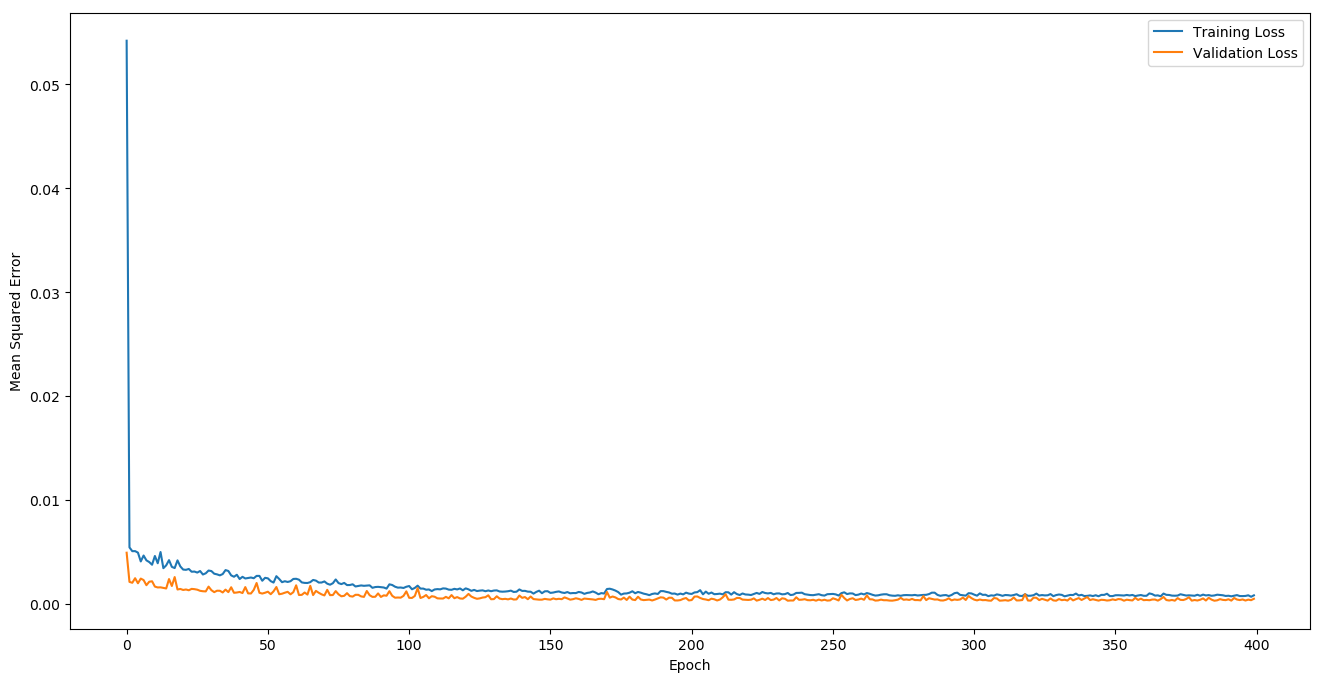

In [16]:
## visualising training history
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')
ax.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [17]:
total_data = pd.concat((train, test), axis=0) ## conveniet to access past time_steps=60 values

test_indices = test_indices = [i for i in range(len(total_data)) if total_data.index[i].year == 2017] ## indices for year = 2017

inputs = total_data[min(test_indices)-60:].values ## only the data required for inputs
inputs = inputs.reshape(-1,1)

inputs = scaler.transform(inputs) ## normalizing because model is trained on normalized data

## feature input

X_test = list()
for i in range(time_steps, len(inputs)):
    X_test.append(inputs[i-time_steps:i,0].reshape(time_steps))
    
X_test = np.array(X_test)

## adding dimension to X_test for compatibilty

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [18]:
X_test.shape

(20, 60, 1)

In [19]:
## making predictions

preds = regressor.predict(X_test)

In [20]:
preds

array([[0.9542878 ],
       [0.949533  ],
       [0.9610291 ],
       [0.9577552 ],
       [0.96932554],
       [0.9834703 ],
       [0.9854298 ],
       [0.9831936 ],
       [0.9871302 ],
       [0.9877952 ],
       [0.98707867],
       [0.98553973],
       [0.9847089 ],
       [0.9867733 ],
       [0.98705333],
       [1.0043365 ],
       [1.012569  ],
       [1.0221102 ],
       [1.0200942 ],
       [0.998622  ]], dtype=float32)

In [21]:
## inverse normalizing preds

preds = scaler.inverse_transform(preds)

In [22]:
preds

array([[792.107  ],
       [789.5509 ],
       [795.73083],
       [793.9709 ],
       [800.1906 ],
       [807.79425],
       [808.84766],
       [807.64557],
       [809.7617 ],
       [810.1192 ],
       [809.734  ],
       [808.90674],
       [808.4601 ],
       [809.5699 ],
       [809.7204 ],
       [819.0111 ],
       [823.4365 ],
       [828.56555],
       [827.4818 ],
       [815.9393 ]], dtype=float32)

In [23]:
## adding to test

test['Preds'] = preds

In [24]:
test

,Open,Preds
Date,,
2017-01-03,778.81,792.106995
2017-01-04,788.36,789.550903
2017-01-05,786.08,795.730835
2017-01-06,795.26,793.970886
2017-01-09,806.40,800.190613
2017-01-10,807.86,807.794250
2017-01-11,805.00,808.847656
2017-01-12,807.14,807.645569
2017-01-13,807.48,809.761719


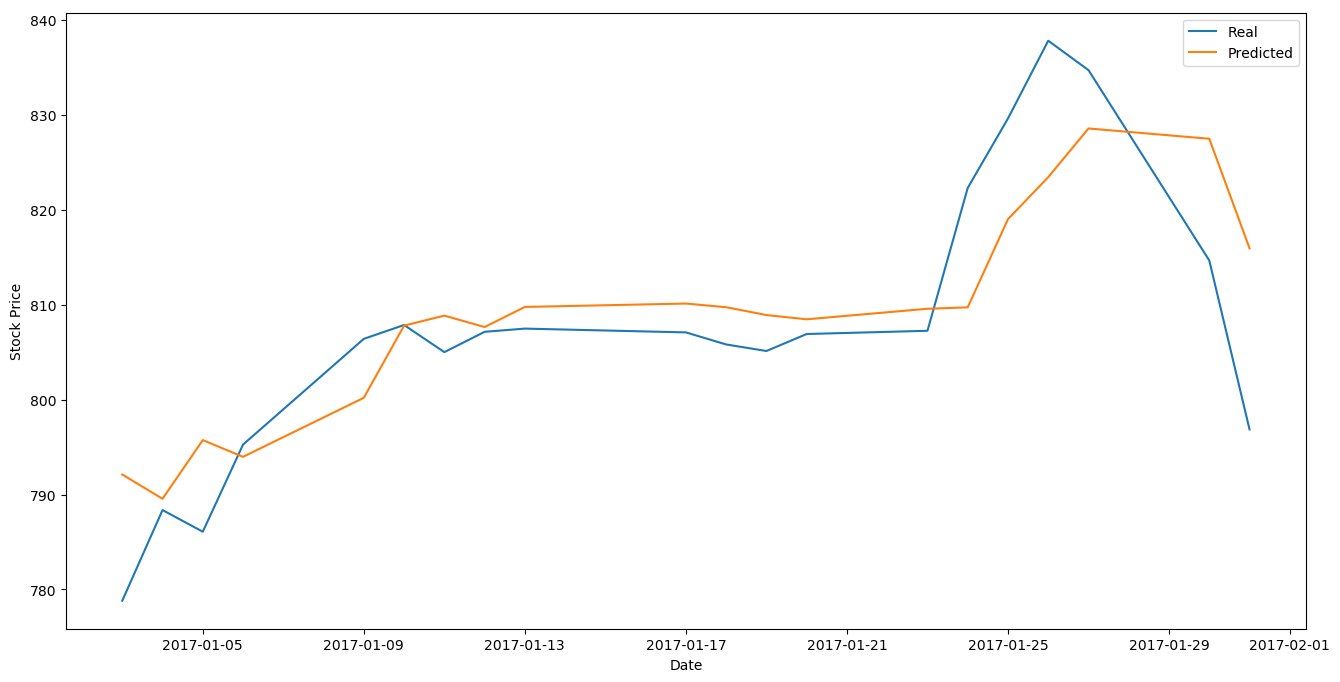

In [25]:
## visualising results

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(test['Open'])
ax.plot(test['Preds'])
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend(['Real', 'Predicted'])

plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [27]:
print(f"Mean Absolute Error: {mean_absolute_error(test['Open'],test['Preds'])}")

Mean Absolute Error: 6.428267211914061


In [28]:
print(f"Root Mean Squared Error: {mean_squared_error(test['Open'],test['Preds'])**(1/2)}")

Root Mean Squared Error: 8.43260902145831


In [30]:
print(f"R-Squared Score: {r2_score(test['Open'],test['Preds'])}")

R-Squared Score: 0.6728213485203205


In [33]:
tensorflow.keras.models.save_model(regressor, 'GoogleStockPrice_LSTM_BatchSize32_Epochs400_R2Score67.h5')